In [ ]:
import pandas as pd
import re
import nltk
import numpy as np
nltk.download(["names",
               "stopwords",
               "state_union",
               "twitter_samples",
               "movie_reviews",
               "averaged_perceptron_tagger",
               "vader_lexicon",
               "punkt"])


# Preprocessing

In [4]:
ecb_df = pd.read_csv('ecb_data.csv')
ecb_df['text'] = ecb_df.apply(lambda x: re.sub(str(x['title']), '', str(x['text'])), axis=1)
ecb_df = ecb_df.rename(columns={"Unnamed: 0": "index ecb"})

In [5]:
fed_df = pd.read_csv('fed_data.csv')
fed_df['text'] = fed_df.apply(lambda x: re.sub(str(x['title']), '', str(x['text'])), axis=1)
fed_df = fed_df.rename(columns={"Unnamed: 0": "index fed"})

In [6]:
train_df = pd.read_csv('train_series.csv')
train_df = train_df.rename(columns={"Unnamed: 0": "index train"})

train_df['index ecb'] = train_df['index ecb'].str.split(',').apply(lambda x: list(map(int, x)))
train_df = train_df.explode('index ecb')
train_df['index ecb'] = train_df['index ecb'].astype(int)

train_df['index fed'] = train_df['index fed'].str.split(',').apply(lambda x: list(map(int, x)))
train_df = train_df.explode('index fed')
train_df['index fed'] = train_df['index fed'].astype(int)

# Sentiment Analysis

In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [8]:
sia = SentimentIntensityAnalyzer()

In [9]:
ecb_df['sentiment_compound_ecb'] = ecb_df.apply(lambda x: sia.polarity_scores(x['text'])['compound'], axis=1)

In [10]:
fed_df['sentiment_compound_fed'] = fed_df.apply(lambda x: sia.polarity_scores(x['text'])['compound'], axis=1)

In [71]:
train_df = pd.read_csv('train_series.csv')
train_df = train_df.rename(columns={"Unnamed: 0": "index train"})
# melt 'index ecb' and 'index fed' columns into rows
df_ecb = pd.melt(train_df, id_vars=['index train', 'Index Name', 'Index - 9', 'Index - 8', 'Index - 7', 'Index - 6', 'Index - 5', 'Index - 4', 'Index - 3', 'Index - 2', 'Index - 1', 'Index - 0', 'Index + 1'], value_vars=['index ecb'], var_name='index', value_name='value')
df_fed = pd.melt(train_df, id_vars=['index train', 'Index Name', 'Index - 9', 'Index - 8', 'Index - 7', 'Index - 6', 'Index - 5', 'Index - 4', 'Index - 3', 'Index - 2', 'Index - 1', 'Index - 0', 'Index + 1'], value_vars=['index fed'], var_name='index', value_name='value')

# set Nan to the right column
df_ecb['index fed'] = pd.NA
df_fed['index ecb'] = pd.NA

# concatenate the two dataframes
result_df = pd.concat([df_ecb, df_fed], ignore_index=True)
result_df = result_df.drop(columns=['index ecb', 'index fed'])

result_df['value'] = result_df['value'].str.split(',').apply(lambda x: list(map(int, x)))
result_df = result_df.explode('value')
result_df['value'] = result_df['value'].astype(int)

result_df_ecb = pd.merge(result_df, ecb_df[['index ecb', 'sentiment_compound_ecb']], left_on='value', right_on='index ecb')
result_df_ecb = result_df_ecb[(result_df_ecb['index'] == 'index ecb')]

result_df_fed = pd.merge(result_df, fed_df[['index fed', 'sentiment_compound_fed']], left_on='value', right_on='index fed')
result_df_fed = result_df_fed[(result_df_fed['index'] == 'index fed')]

final_df = pd.concat([result_df_fed, result_df_ecb], axis=0)
final_df['sentiment_compound'] = final_df.apply(lambda x: x['sentiment_compound_ecb'] if ~np.isnan(x['sentiment_compound_ecb']) else x['sentiment_compound_fed'], axis=1)

final_df = final_df.drop(columns=['index ecb', 'index fed', 'value', 'index', 'sentiment_compound_fed', 'sentiment_compound_ecb'])

final_df['sentiment_sign'] = final_df.apply(lambda x: 1 if x['sentiment_compound']>0 else -1, axis=1)
final_df['label'] = final_df.apply(lambda x: 1 if x['Index + 1']>0 else -1, axis=1)

final_df = final_df.groupby('index train').mean()


In [72]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8946 entries, 0 to 8945
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Index - 9           8946 non-null   float64
 1   Index - 8           8946 non-null   float64
 2   Index - 7           8946 non-null   float64
 3   Index - 6           8946 non-null   float64
 4   Index - 5           8946 non-null   float64
 5   Index - 4           8946 non-null   float64
 6   Index - 3           8946 non-null   float64
 7   Index - 2           8946 non-null   float64
 8   Index - 1           8946 non-null   float64
 9   Index - 0           8946 non-null   float64
 10  Index + 1           8946 non-null   float64
 11  sentiment_compound  8946 non-null   float64
 12  sentiment_sign      8946 non-null   float64
 13  label               8946 non-null   float64
dtypes: float64(14)
memory usage: 1.0 MB


In [73]:
corr = final_df.corr()


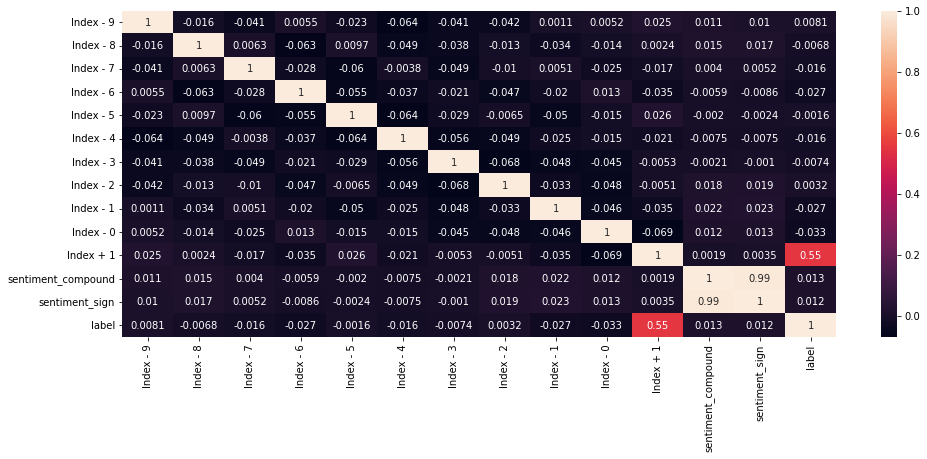

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

sns.heatmap(corr, annot=True);
